### Dependences

In [1]:
import sys
sys.path.append("../")

import numpy as np
import tensorflow as tf

from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
from IPython.display import clear_output

from lib.models.UNet import UNet
import lib.utils as utils


### Loading experiment data

In [2]:
#set experiment ID
EXP_ID = "UNet"
utils.create_experiment_folders(EXP_ID)
utils.load_experiment_data()


### Model instantiation

In [3]:
model = UNet()
model.build((None,128,128,1))
print(model.summary())


Model: "u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
sequential (Sequential)      multiple                  448       
_________________________________________________________________
sequential_1 (Sequential)    multiple                  18752     
_________________________________________________________________
sequential_2 (Sequential)    multiple                  74368     
_________________________________________________________________
sequential_3 (Sequential)    multiple                  296192    
_________________________________________________________________
sequential_4 (Sequential)    multiple                  1182208   
_________________________________________________________________
sequential_5 (Sequential)    multiple                  472371

### Loading Dataset

In [4]:
train_x = np.load("../../dataset/X.npy") 
train_y = np.load("../../dataset/Y.npy") 

for i in range(0,1000):
    train_x = np.concatenate((train_x, np.load("../../dataset/X.npy")), axis=0)
    train_y = np.concatenate((train_y, np.load("../../dataset/Y.npy")), axis=0)

qtd_traning = train_x.shape
print("Loaded",qtd_traning, "samples")


Loaded (1001, 128, 128, 1) samples


In [5]:
valid_x = np.load("../../dataset/X.npy") 
valid_y = np.load("../../dataset/Y.npy") 


qtd_traning = train_x.shape
print("Loaded",qtd_traning, "samples")


Loaded (1001, 128, 128, 1) samples


### Dataset Normalization and Batches split

0.0 322.15356
0.001 1.001
train_batches: 126 valid_batches: 1
Preview examples from train set
batch 0


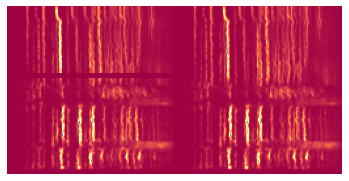

batch 1


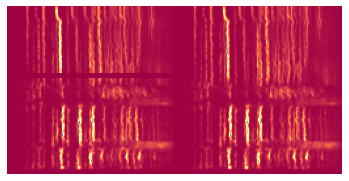

In [6]:
print(np.amin(train_x), np.amax(train_x))

SHIFT_VALUE_X, SHIFT_VALUE_Y, SCALE_VALUE_X, SCALE_VALUE_Y = utils.get_shift_scale_maxmin(train_x, train_y, valid_x, valid_y)

train_x = utils.shift_and_normalize(train_x, SHIFT_VALUE_X, SCALE_VALUE_X)
train_y = utils.shift_and_normalize(train_y, SHIFT_VALUE_Y, SCALE_VALUE_Y)

valid_x = utils.shift_and_normalize(valid_x, SHIFT_VALUE_X, SCALE_VALUE_X)
valid_y = utils.shift_and_normalize(valid_y, SHIFT_VALUE_Y, SCALE_VALUE_Y)

print(np.amin(train_x), np.amax(train_x))

train_batches = utils.random_mini_batches(train_x, train_y, None, None, 8, seed=0)
valid_batches = utils.random_mini_batches(valid_x, valid_y, None, None, 8, seed=0)


print("train_batches:", len(train_batches), "valid_batches:", len(valid_batches))


print("Preview examples from train set")
for index,batch in enumerate(train_batches):
    if index > 1:
        break
    (seismic_x, seismic_y, _, _) = batch
    print("batch", index)
    plt.imshow( np.hstack((seismic_x[0,:,:,0], seismic_y[0,:,:,0])) , cmap='Spectral', vmin=0, vmax=1)
    plt.axis('off')
    plt.pause(0.1)
    


### Metrics

In [7]:
#default tf.keras metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')


### Set Loss and load model weights

In [8]:
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#get last saved epoch index and best result in validation step
CURRENT_EPOCH, BEST_VALIDATION = utils.get_model_last_data()
if CURRENT_EPOCH > 0:
    print("Loading last model state in epoch", CURRENT_EPOCH)
    model.load_weights(utils.get_exp_folder_last_epoch())
    print("Best validation result was PSNR=", BEST_VALIDATION)

### Training

VALIDATION EPOCH 9
Spatial domain: X - Y - PREDICT


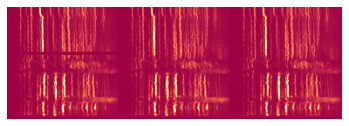

Spatial domain: X - Y - PREDICT


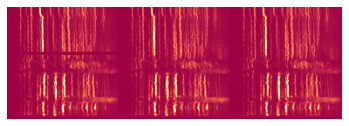

Spatial domain: X - Y - PREDICT


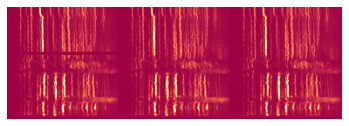

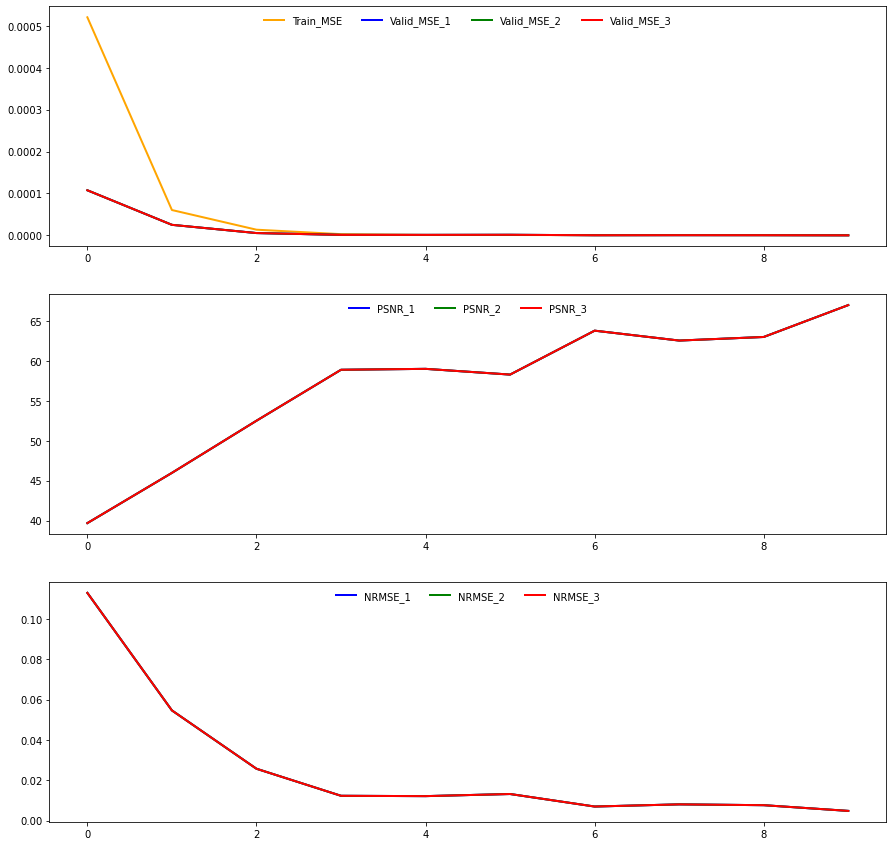

In [9]:
@tf.function
def train_step(patch_x, patch_y):
    with tf.GradientTape() as tape:
        predictions = model(patch_x)
        loss = loss_object(patch_y, predictions)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)

def valid_step(valid_batches):
    valid_mse = tf.keras.metrics.MeanSquaredError(name='train_mse')
    valid_custom_metrics = utils.CustomMetric()
    for index, batch in enumerate(valid_batches):
        (data_x, data_y, _, _) = batch
        predictions = model(seismic_x)
        valid_mse(seismic_y, predictions)

        predictions = predictions.numpy()

        #feed the metric evaluator
        valid_custom_metrics.feed(seismic_y, predictions)

        #just show the first example of the first batch
        if index == 0:
            print("Spatial domain: X - Y - PREDICT")
            plt.imshow(np.hstack((data_x[0,:,:,0], data_y[0,:,:,0], predictions[0,:,:,0])) , cmap='Spectral', vmin=0, vmax=1)
            plt.axis('off')
            plt.pause(0.1)
    
    #get metric results
    psnr, nrmse = valid_custom_metrics.result()
    valid_mse_result = valid_mse.result().numpy()
    valid_custom_metrics.reset_states()
    valid_mse.reset_states()
    return psnr, nrmse, valid_mse_result
    
MAX_EPOCHS = 10
EVAL_STEP = 1

for epoch in range(CURRENT_EPOCH, MAX_EPOCHS):
    
    #TRAINING
    print("TRAINING EPOCH", epoch)
   
    for batch in train_batches:
        (seismic_x, seismic_y, _, _) = batch
        train_step(seismic_x, seismic_y)
        
    
    #VALIDATION
    if epoch%EVAL_STEP == 0:
        clear_output()
        
        print("VALIDATION EPOCH", epoch)
        #saving last epoch model
        model.save_weights(utils.get_exp_folder_last_epoch(), save_format='tf')
       
        #valid with set 1
        print("Validation set 1")
        psnr_1, nrmse_1, mse_1 = valid_step(valid_batches)
        
        #valid with set 2
        print("Validation set 2")
        psnr_2, nrmse_2, mse_2 = valid_step(valid_batches)
        
        #valid with set 3
        print("Validation set 3")
        psnr_3, nrmse_3, mse_3 = valid_step(valid_batches)
        
        utils.update_chart_data(epoch=epoch, train_mse=train_loss.result().numpy(), 
                                valid_mse=[mse_1,mse_2,mse_3], psnr=[psnr_1,psnr_2,psnr_3], nrmse=[nrmse_1,nrmse_2, nrmse_3])
        utils.draw_chart()
        
        #saving best validation model
        if psnr_1 > BEST_VALIDATION:
            BEST_VALIDATION = psnr_1
            model.save_weights(utils.get_exp_folder_best_valid(), save_format='tf')
        
    train_loss.reset_states()


In [10]:
#experimentos results
print(utils.get_experiment_results())

{'Best_Valid': 67.0306807758704, 'Best_Epoch': 9, 'PSNR_1': 67.0306807758704, 'PSNR_2': 67.03067428151031, 'PSNR_3': 67.03068068310417, 'NRMSE_1': 0.004844610484862351, 'NRMSE_2': 0.0048446141071345605, 'NRMSE_3': 0.004844610536603305}


## Test

Loaded (101, 128, 128, 1) samples
Spatial domain: X - Y - PREDICT - DIFF


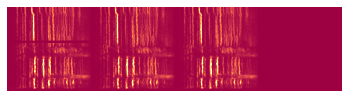

Spatial domain: X - Y - PREDICT - DIFF


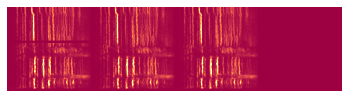

Spatial domain: X - Y - PREDICT - DIFF


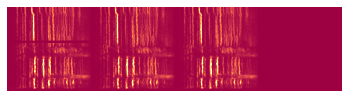

Spatial domain: X - Y - PREDICT - DIFF


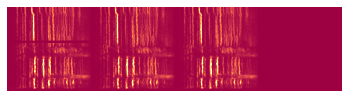

Spatial domain: X - Y - PREDICT - DIFF


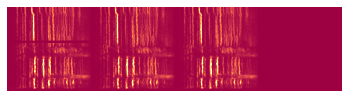

Spatial domain: X - Y - PREDICT - DIFF


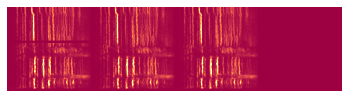

Spatial domain: X - Y - PREDICT - DIFF


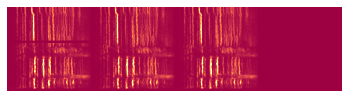

Spatial domain: X - Y - PREDICT - DIFF


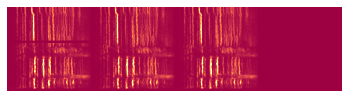

Spatial domain: X - Y - PREDICT - DIFF


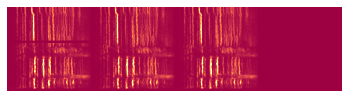

Spatial domain: X - Y - PREDICT - DIFF


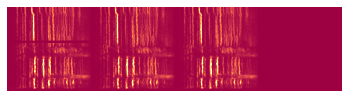

Spatial domain: X - Y - PREDICT - DIFF


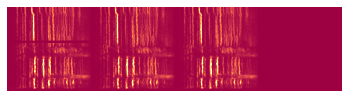

Spatial domain: X - Y - PREDICT - DIFF


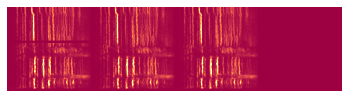

Spatial domain: X - Y - PREDICT - DIFF


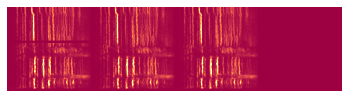

PSNR: 67.03067901619512 
NRMSE 0.004844611466332753


In [16]:
#load best model
model.load_weights(utils.get_exp_folder_best_valid())

test_x = np.load("../../dataset/X.npy") 
test_y = np.load("../../dataset/Y.npy") 

for i in range(0,100):
    test_x = np.concatenate((test_x, np.load("../../dataset/X.npy")), axis=0)
    test_y = np.concatenate((test_y, np.load("../../dataset/Y.npy")), axis=0)

qtd_traning = test_x.shape
print("Loaded",qtd_traning, "samples")

#normalization
test_x = utils.shift_and_normalize(test_x, SHIFT_VALUE_X, SCALE_VALUE_X)
test_y = utils.shift_and_normalize(test_y, SHIFT_VALUE_Y, SCALE_VALUE_Y) 

#batches
test_batches = utils.random_mini_batches(test_x, test_y, None, None, 8, seed=0)

#metrics
test_mse = tf.keras.metrics.MeanSquaredError(name='train_mse')
test_custom_metrics = utils.CustomMetric()

#test
for index, batch in enumerate(test_batches):
    (data_x, data_y, _, _) = batch
    predictions = model(seismic_x)
    test_mse(seismic_y, predictions)

    predictions = predictions.numpy()

    #feed the metric evaluator
    test_custom_metrics.feed(seismic_y, predictions)

    #just show the first example of each batch until 5    
    print("Spatial domain: X - Y - PREDICT - DIFF")
    plt.imshow(np.hstack((data_x[0,:,:,0], data_y[0,:,:,0], predictions[0,:,:,0], np.abs(predictions[0,:,:,0]-seismic_y[0,:,:,0]))) , cmap='Spectral', vmin=0, vmax=1)
    plt.axis('off')
    plt.pause(0.1)
    
    #predictions = inv_shift_and_normalize(predictions, SHIFT_VALUE_Y, SCALE_VALUE_Y)
    #np.save(outfile_path, predictions)
    
#get metric results
psnr, nrmse = test_custom_metrics.result()
test_mse_result = test_mse.result().numpy()
test_custom_metrics.reset_states()
test_mse.reset_states()
    
print("PSNR:", psnr,"\nNRMSE", nrmse)

 
